# `CNRatioModel` Tutorial

Trey V. Wenger (c) December 2024

`CNRatioModel` models both ${\rm CN}$ and $^{13}{\rm CN}$ spectral simultaneously in order to constrain the isotopic ratio $^{12}{\rm C}/^{13}{\rm C}$. The model is similar to `CNModel`, with the following assumptions and limitations:

1. Hyperfine anomalies are only (optionally) predicted for ${\rm CN}$. We assume that $^{13}{\rm CN}$ does not suffer from hyperfine anomalies.
2. We assume that the cloud mean ${\rm CN}$ excitation temperature is equal to the cloud mean $^{13}{\rm CN}$ excitation temperature.
3. The ratio parameter `log10_12C_13C_ratio` is only equivalent to the "true" isotopic ratio under the assumption that both species have the same excitation conditions (i.e., the same population fraction in the $N=0$ and $N=1$ states). This parameter is equivalent to the total column density ratio of all $N=0$ and $N=1$ states, $N_{\rm tot, CN}/N_{\rm tot, $13CN}$ where $N_{\rm tot} = \sum N_{N=0} + N_{N=1}$, which we assume is the same ratio over *all* states.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+5.gba85b08.dirty


## Simulate Data

We do not fix kinetic temperature for simulation.

12CN-1 450
12CN-2 300
13CN-1 250
13CN-2 250
Transition 113144.19 is constraining upper state 2 from lower state 1
Transition 113191.325 is constraining upper state 3 from lower state 1
Transition 113490.985 is constraining upper state 1 from lower state 1
Transition 113508.934 is constraining upper state 0 from lower state 1
Transition 113520.4215 is constraining upper state 4 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 2
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 108631.121 is constraining upper state 1 from lower state 3
Transition 108636.923 is constraining upper state 2 from lower state 3
Transition 108651.297 is constraining upper state 4 from lower state 3
Transition 108986.8678 is constraining upper state 0 from lower state 3
Transition 109217.6017 is constraining

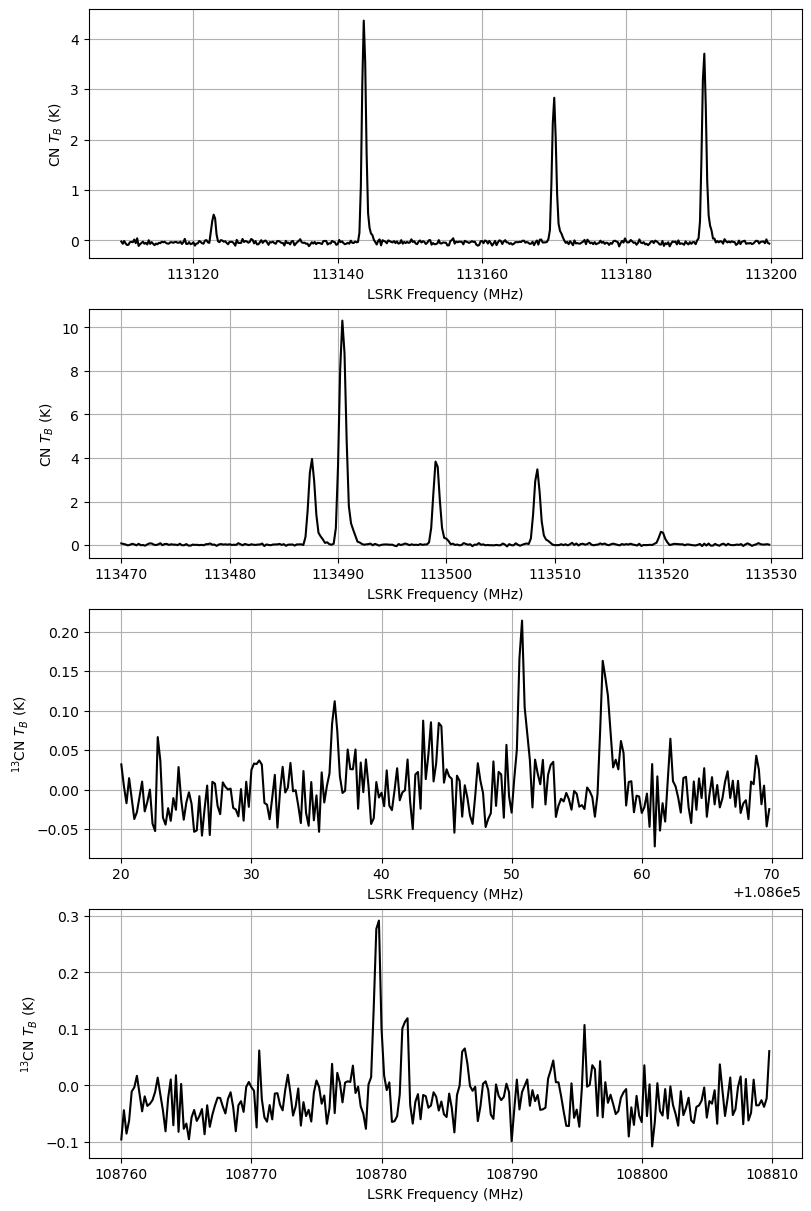

In [30]:
import astropy.constants as c
from bayes_spec import SpecData
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108760.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0_12CN = [13.5, 0.25], # mean and width of log10 12CN ground state column density prior (cm-2)
    prior_log10_N0_13CN = [11.5, 0.25], # mean and width of log10 13CN ground state column density prior (cm-2)
    prior_log10_Tex = [1.5, 0.25], # mean and width of log10 cloud mean excitation temperature prior (K)
    prior_log10_Tkin = [1.0, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_12CN_sigma = 0.1, # width of hyperfine anomaly prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# here we specify the normalized log boltzmann factor offset for simplicity
rng = np.random.RandomState(seed=1234)
log_boltz_factor_12CN_sigma_norm = np.array([1.0, 0.5])
log_boltz_factor_12CN_free_norm = log_boltz_factor_12CN_sigma_norm * rng.normal(size=(len(model.model.coords["transition_free_12CN"]), n_clouds))

sim_params = {
    "log10_N0_12CN": [13.7, 12.6],
    "log10_N0_13CN": [11.9, 10.8],
    "log10_Tkin": [1.2, 1.5],
    "log10_Tex_mean": [1.2, 1.3],
    "fwhm_nonthermal": [1.5, 2.0],
    "velocity": [1.5, -0.5],
    "fwhm_L": 0.0,
    "baseline_12CN_norm": [0.0],
    "baseline_13CN_norm": [0.0],
    "log_boltz_factor_12CN_sigma": 0.1 * log_boltz_factor_12CN_sigma_norm,
    "log_boltz_factor_12CN_free_norm": log_boltz_factor_12CN_free_norm,
}
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

tau_12CN = model.model.tau_12CN.eval(sim_params, on_unused_input="ignore")
tau_13CN = model.model.tau_13CN.eval(sim_params, on_unused_input="ignore")
tau_total_12CN = model.model.tau_total_12CN.eval(sim_params, on_unused_input="ignore")
tau_total_13CN = model.model.tau_total_13CN.eval(sim_params, on_unused_input="ignore")
log10_N_12CN = model.model.log10_N_12CN.eval(sim_params, on_unused_input="ignore")
log10_N_13CN = model.model.log10_N_13CN.eval(sim_params, on_unused_input="ignore")
log10_12C_13C_ratio = model.model.log10_12C_13C_ratio.eval(sim_params, on_unused_input="ignore")

derived_params = {
    "log10_N_12CN": log10_N_12CN,
    "tau_total_12CN": tau_total_12CN,
    "log10_N_13CN": log10_N_13CN,
    "tau_total_13CN": tau_total_13CN,
    "log10_12C_13C_ratio": log10_12C_13C_ratio,
}

print()
print("tau:")
print(tau_12CN)
print(tau_13CN)

print()
print("tau_total:")
print(tau_total_12CN)
print(tau_total_13CN)

print()
print("log10_N:")
print(log10_N_12CN)
print(log10_N_13CN)

print()
print("log10_12C_13C_ratio")
print(log10_12C_13C_ratio)

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}
for label, dataset in data.items():
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Plot the simulated data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, dataset in enumerate(data.values()):
    axes[i].plot(dataset.spectral, dataset.brightness, 'k-')
    axes[i].set_ylabel(dataset.ylabel)
    _ = axes[i].set_xlabel(dataset.xlabel)

## Model Definition

In [38]:
# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0_12CN = [13.5, 0.25], # mean and width of log10 12CN ground state column density prior (cm-2)
    prior_log10_N0_13CN = [11.5, 0.25], # mean and width of log10 13CN ground state column density prior (cm-2)
    prior_log10_Tex = None, # weak LTE assumption
    prior_log10_Tkin = [1.0, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # weak LTE assumption kinetic temperature = mean cloud excitation temperature
    prior_log_boltz_factor_12CN_sigma = 0.1, # width of hyperfine anomaly prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 2 from lower state 1
Transition 113191.325 is constraining upper state 3 from lower state 1
Transition 113490.985 is constraining upper state 1 from lower state 1
Transition 113508.934 is constraining upper state 0 from lower state 1
Transition 113520.4215 is constraining upper state 4 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 2
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 108631.121 is constraining upper state 1 from lower state 3
Transition 108636.923 is constraining upper state 2 from lower state 3
Transition 108651.297 is constraining upper state 4 from lower state 3
Transition 108986.8678 is constraining upper state 0 from lower state 3
Transition 109217.6017 is constraining upper state 3 from lower state 3
Transition

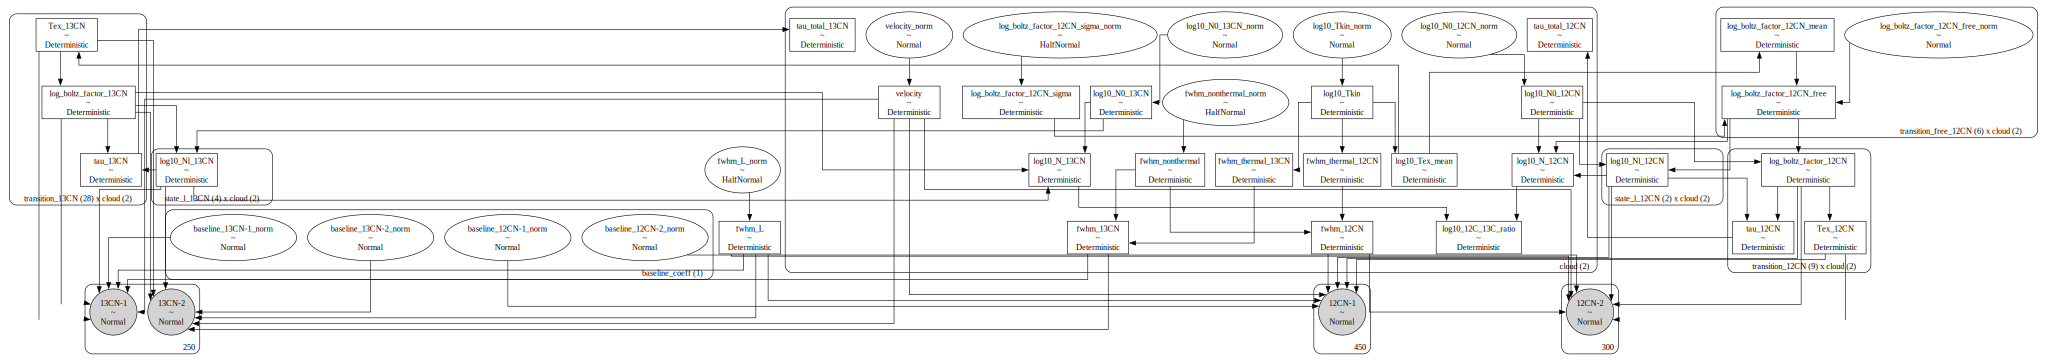

In [39]:
# Plot model graph
model.graph().render('cn_ratio_model', format='png')
model.graph()

In [40]:
# model string representation
print(model.model.str_repr())

            baseline_12CN-1_norm ~ Normal(0, 1)
            baseline_12CN-2_norm ~ Normal(0, 1)
            baseline_13CN-1_norm ~ Normal(0, 1)
            baseline_13CN-2_norm ~ Normal(0, 1)
              log10_N0_12CN_norm ~ Normal(0, 1)
              log10_N0_13CN_norm ~ Normal(0, 1)
                 log10_Tkin_norm ~ Normal(0, 1)
log_boltz_factor_12CN_sigma_norm ~ HalfNormal(0, 1)
 log_boltz_factor_12CN_free_norm ~ Normal(0, 1)
                   velocity_norm ~ Normal(0, 1)
            fwhm_nonthermal_norm ~ HalfNormal(0, 1)
                     fwhm_L_norm ~ HalfNormal(0, 1)
                   log10_N0_12CN ~ Deterministic(f(log10_N0_12CN_norm))
                   log10_N0_13CN ~ Deterministic(f(log10_N0_13CN_norm))
                      log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
                  log10_Tex_mean ~ Deterministic(f(log10_Tkin_norm))
                        Tex_13CN ~ Deterministic(f(log10_Tkin_norm))
           log_boltz_factor_13CN ~ Deterministic(f(log10_Tkin

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_12CN_norm, log10_N0_13CN_norm, log10_Tkin_norm, log_boltz_factor_12CN_free_norm, log_boltz_factor_12CN_sigma_norm, velocity_norm]


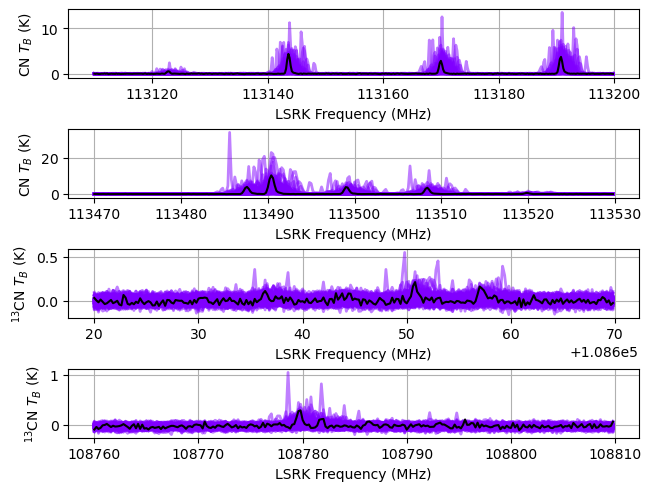

In [41]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [42]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 8300
Interrupted at 8,299 [8%]: Average Loss = 5,853


Output()

Runtime: 2.28 minutes


In [43]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_free_12CN", "transition_12CN", "transition_13CN", "state_l_12CN", "state_l_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
log10_N0_12CN[0]                12.673  0.007  12.660   12.686      0.000   
log10_N0_12CN[1]                13.726  0.001  13.725   13.728      0.000   
log10_N0_13CN[0]                11.112  0.114  10.907   11.327      0.004   
log10_N0_13CN[1]                11.889  0.018  11.854   11.921      0.001   
log10_Tkin[0]                    1.178  0.013   1.155    1.201      0.000   
log10_Tkin[1]                    1.215  0.001   1.213    1.217      0.000   
log10_Tex_mean[0]                1.178  0.013   1.155    1.201      0.000   
log10_Tex_mean[1]                1.215  0.001   1.213    1.217      0.000   
log10_N_13CN[0]                 12.208  0.114  11.990   12.411      0.004   
log10_N_13CN[1]                 12.993  0.018  12.961   13.028      0.001   
log_boltz_factor_12CN_sigma[0]   0.013  0.017   0.000    0.042      0.001   
log_boltz_factor_12CN_sigma[1]   0.062  0.001   0.060    0.063      0.000   
log10_N_12CN[0]                 13.339  0.008  13.325   13.356      0.000   
log10_N_12CN[1]                 14.406  0.001  14.404   14.408      0.000   
log10_12C_13C_ratio[0]           1.131  0.114   0.926    1.351      0.004   
log10_12C_13C_ratio[1]           1.413  0.018   1.379    1.446      0.001   
velocity[0]                     -0.401  0.026  -0.446   -0.351      0.001   
velocity[1]                      1.498  0.002   1.496    1.501      0.000   
fwhm_thermal_12CN[0]             0.163  0.002   0.158    0.167      0.000   
fwhm_thermal_12CN[1]             0.170  0.000   0.170    0.170      0.000   
fwhm_thermal_13CN[0]             0.160  0.002   0.155    0.164      0.000   
fwhm_thermal_13CN[1]             0.167  0.000   0.166    0.167      0.000   
fwhm_nonthermal[0]               2.244  0.045   2.165    2.336      0.001   
fwhm_nonthermal[1]               1.470  0.003   1.464    1.476      0.000   
fwhm_12CN[0]                     2.250  0.045   2.171    2.342      0.001   
fwhm_12CN[1]                     1.480  0.003   1.473    1.485      0.000   
fwhm_13CN[0]                     2.250  0.045   2.170    2.342      0.001   
fwhm_13CN[1]                     1.479  0.003   1.473    1.485      0.000   
tau_total_12CN[0]                0.210  0.010   0.196    0.228      0.000   
tau_total_12CN[1]                2.451  0.016   2.422    2.480      0.001   
tau_total_13CN[0]                0.015  0.004   0.008    0.022      0.000   
tau_total_13CN[1]                0.079  0.003   0.073    0.085      0.000   
fwhm_L                           0.005  0.005   0.000    0.014      0.000   
baseline_12CN-1_norm[0]         -0.186  0.053  -0.280   -0.083      0.002   
baseline_12CN-2_norm[0]         -0.283  0.063  -0.401   -0.168      0.002   
baseline_13CN-1_norm[0]         -0.193  0.075  -0.331   -0.048      0.003   
baseline_13CN-2_norm[0]         -0.124  0.062  -0.239   -0.006      0.002   

                                mcse_sd  ess_bulk  ess_tail  r_hat  
log10_N0_12CN[0]                  0.000     988.0    1000.0    NaN  
log10_N0_12CN[1]                  0.000     999.0    1024.0    NaN  
log10_N0_13CN[0]                  0.003     979.0     836.0    NaN  
log10_N0_13CN[1]                  0.000     903.0     941.0    NaN  
log10_Tkin[0]                     0.000     978.0    1026.0    NaN  
log10_Tkin[1]                     0.000    1034.0     934.0    NaN  
log10_Tex_mean[0]                 0.000     978.0    1026.0    NaN  
log10_Tex_mean[1]                 0.000    1034.0     934.0    NaN  
log10_N_13CN[0]                   0.003     975.0     867.0    NaN  
log10_N_13CN[1]                   0.000     902.0     941.0    NaN  
log_boltz_factor_12CN_sigma[0]    0.000     889.0     690.0    NaN  
log_boltz_factor_12CN_sigma[1]    0.000     888.0     990.0    NaN  
log10_N_12CN[0]                   0.000     964.0     992.0    NaN  
log10_N_12CN[1]                   0.000     812.0     908.0    NaN  
log10_12C_13C_ratio[0]            0.003     975.0     878.0    NaN  
log

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

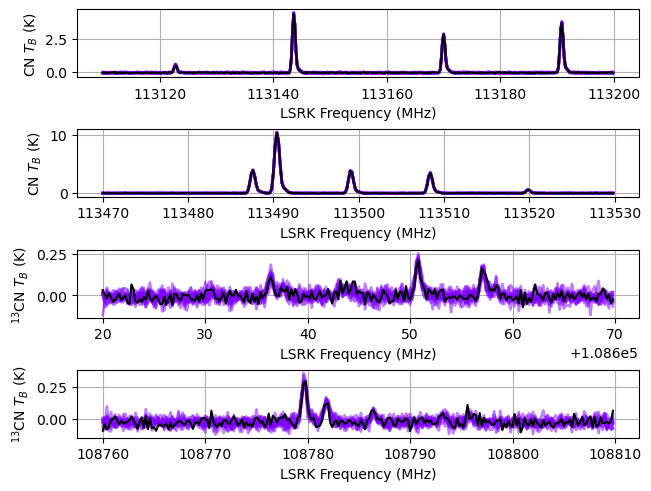

In [44]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [45]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8300
Interrupted at 8,299 [8%]: Average Loss = 5,853
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, log10_N0_12CN_norm, log10_N0_13CN_norm, log10_Tkin_norm, log_boltz_factor_12CN_sigma_norm, log_boltz_factor_12CN_free_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 5206 seconds.


Adding log-likelihood to trace


Output()

There were 268 divergences in converged chains.
Runtime: 91.88 minutes


In [48]:
model._cluster_features = ['log10_N0_12CN', 'fwhm_12CN', 'velocity']

In [49]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [56]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        "transition_12CN", "transition_free_12CN", "transition_13CN",
        "state_l_12CN", "state_l_13CN"
    ]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
log10_N0_12CN[0]                12.668  0.044  12.584   12.746      0.001   
log10_N0_12CN[1]                13.724  0.009  13.706   13.742      0.000   
log10_N0_13CN[0]                11.099  0.118  10.881   11.322      0.001   
log10_N0_13CN[1]                11.880  0.029  11.823   11.933      0.001   
log10_Tkin[0]                    1.228  0.104   1.034    1.421      0.001   
log10_Tkin[1]                    1.230  0.053   1.139    1.334      0.001   
log10_Tex_mean[0]                1.228  0.104   1.034    1.421      0.001   
log10_Tex_mean[1]                1.230  0.053   1.139    1.334      0.001   
log10_N_13CN[0]                 12.204  0.116  11.982   12.414      0.001   
log10_N_13CN[1]                 12.987  0.022  12.945   13.031      0.001   
log_boltz_factor_12CN_sigma[0]   0.023  0.021   0.000    0.060      0.000   
log_boltz_factor_12CN_sigma[1]   0.090  0.027   0.050    0.144      0.001   
log10_N_12CN[0]                 13.344  0.034  13.283   13.409      0.001   
log10_N_12CN[1]                 14.403  0.007  14.390   14.416      0.000   
log10_12C_13C_ratio[0]           1.140  0.115   0.931    1.356      0.001   
log10_12C_13C_ratio[1]           1.416  0.022   1.375    1.459      0.001   
velocity[0]                     -0.360  0.091  -0.527   -0.196      0.002   
velocity[1]                      1.502  0.005   1.493    1.510      0.000   
fwhm_thermal_12CN[0]             0.174  0.022   0.138    0.215      0.000   
fwhm_thermal_12CN[1]             0.173  0.011   0.155    0.194      0.000   
fwhm_thermal_13CN[0]             0.171  0.021   0.135    0.211      0.000   
fwhm_thermal_13CN[1]             0.170  0.011   0.152    0.190      0.000   
fwhm_nonthermal[0]               2.253  0.147   1.976    2.522      0.003   
fwhm_nonthermal[1]               1.475  0.010   1.457    1.494      0.000   
fwhm_12CN[0]                     2.259  0.147   1.981    2.528      0.003   
fwhm_12CN[1]                     1.485  0.010   1.467    1.504      0.000   
fwhm_13CN[0]                     2.259  0.147   1.981    2.528      0.003   
fwhm_13CN[1]                     1.484  0.010   1.467    1.504      0.000   
tau_total_12CN[0]                0.196  0.052   0.099    0.293      0.001   
tau_total_12CN[1]                2.438  0.102   2.247    2.629      0.001   
tau_total_13CN[0]                0.013  0.005   0.005    0.022      0.000   
tau_total_13CN[1]                0.076  0.012   0.052    0.098      0.000   
fwhm_L                           0.007  0.006   0.000    0.017      0.000   
baseline_12CN-1_norm[0]         -0.174  0.049  -0.266   -0.084      0.000   
baseline_12CN-2_norm[0]         -0.308  0.062  -0.422   -0.189      0.001   
baseline_13CN-1_norm[0]         -0.189  0.066  -0.310   -0.064      0.001   
baseline_13CN-2_norm[0]         -0.136  0.066  -0.251   -0.007      0.001   

                                mcse_sd  ess_bulk  ess_tail  r_hat  
log10_N0_12CN[0]                  0.000    4816.0    4827.0    1.0  
log10_N0_12CN[1]                  0.000    6881.0    5627.0    1.0  
log10_N0_13CN[0]                  0.001    7872.0    5507.0    1.0  
log10_N0_13CN[1]                  0.001    1591.0     758.0    1.0  
log10_Tkin[0]                     0.001    5129.0    4768.0    1.0  
log10_Tkin[1]                     0.001    1455.0    2282.0    1.0  
log10_Tex_mean[0]                 0.001    5129.0    4768.0    1.0  
log10_Tex_mean[1]                 0.001    1455.0    2282.0    1.0  
log10_N_13CN[0]                   0.001    8035.0    5263.0    1.0  
log10_N_13CN[1]                   0.000    1872.0     776.0    1.0  
log_boltz_factor_12CN_sigma[0]    0.000    4193.0    4581.0    1.0  
log_boltz_factor_12CN_sigma[1]    0.000    2296.0    1838.0    1.0  
log10_N_12CN[0]                   0.000    3435.0     841.0    1.0  
log10_N_12CN[1]                   0.000    6070.0    5458.0    1.0  
log10_12C_13C_ratio[0]            0.001    6473.0    5691.0    1.0  
log

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

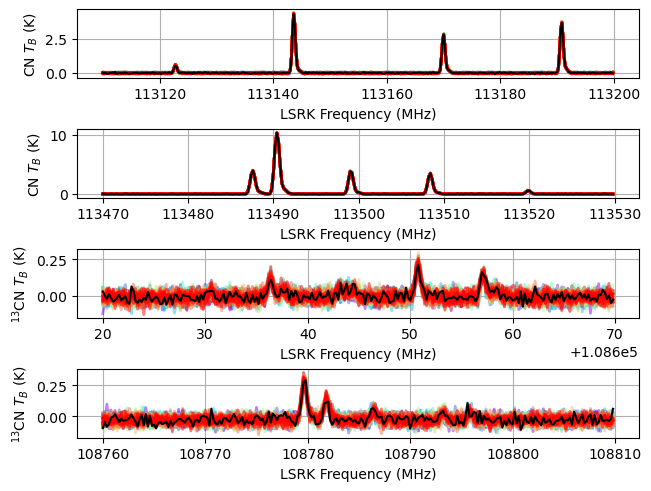

In [51]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

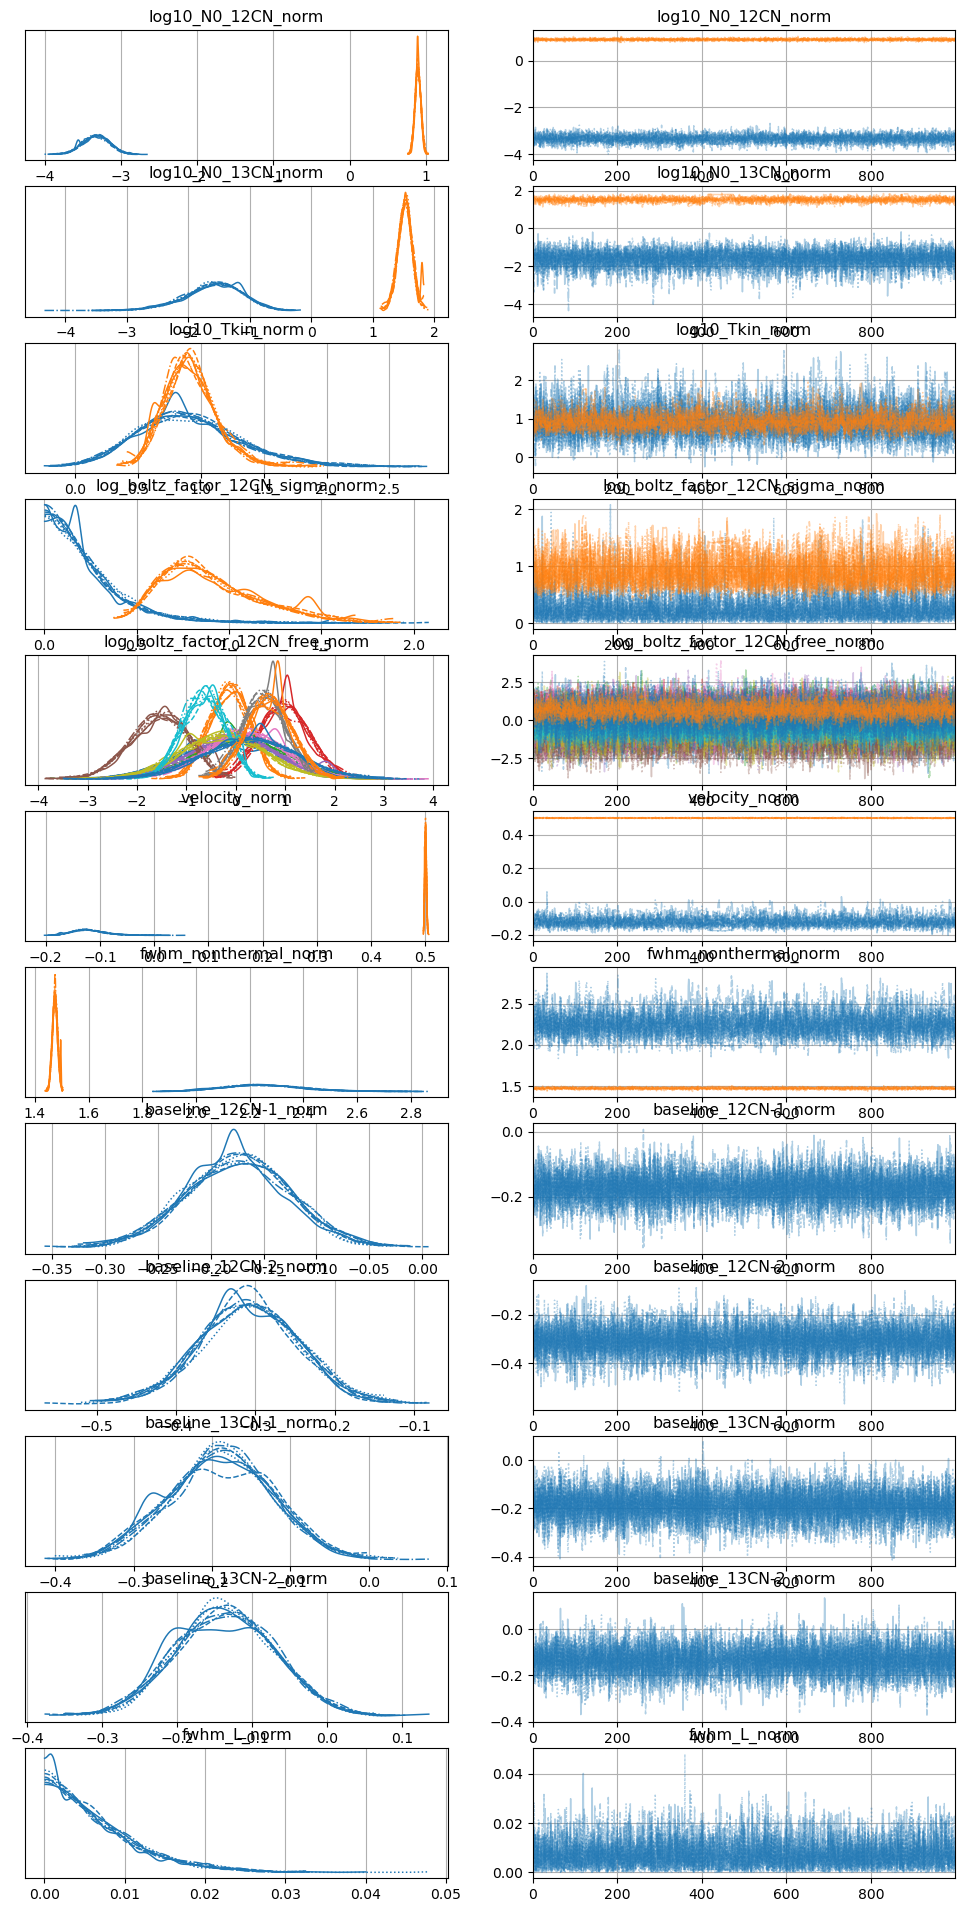

In [52]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

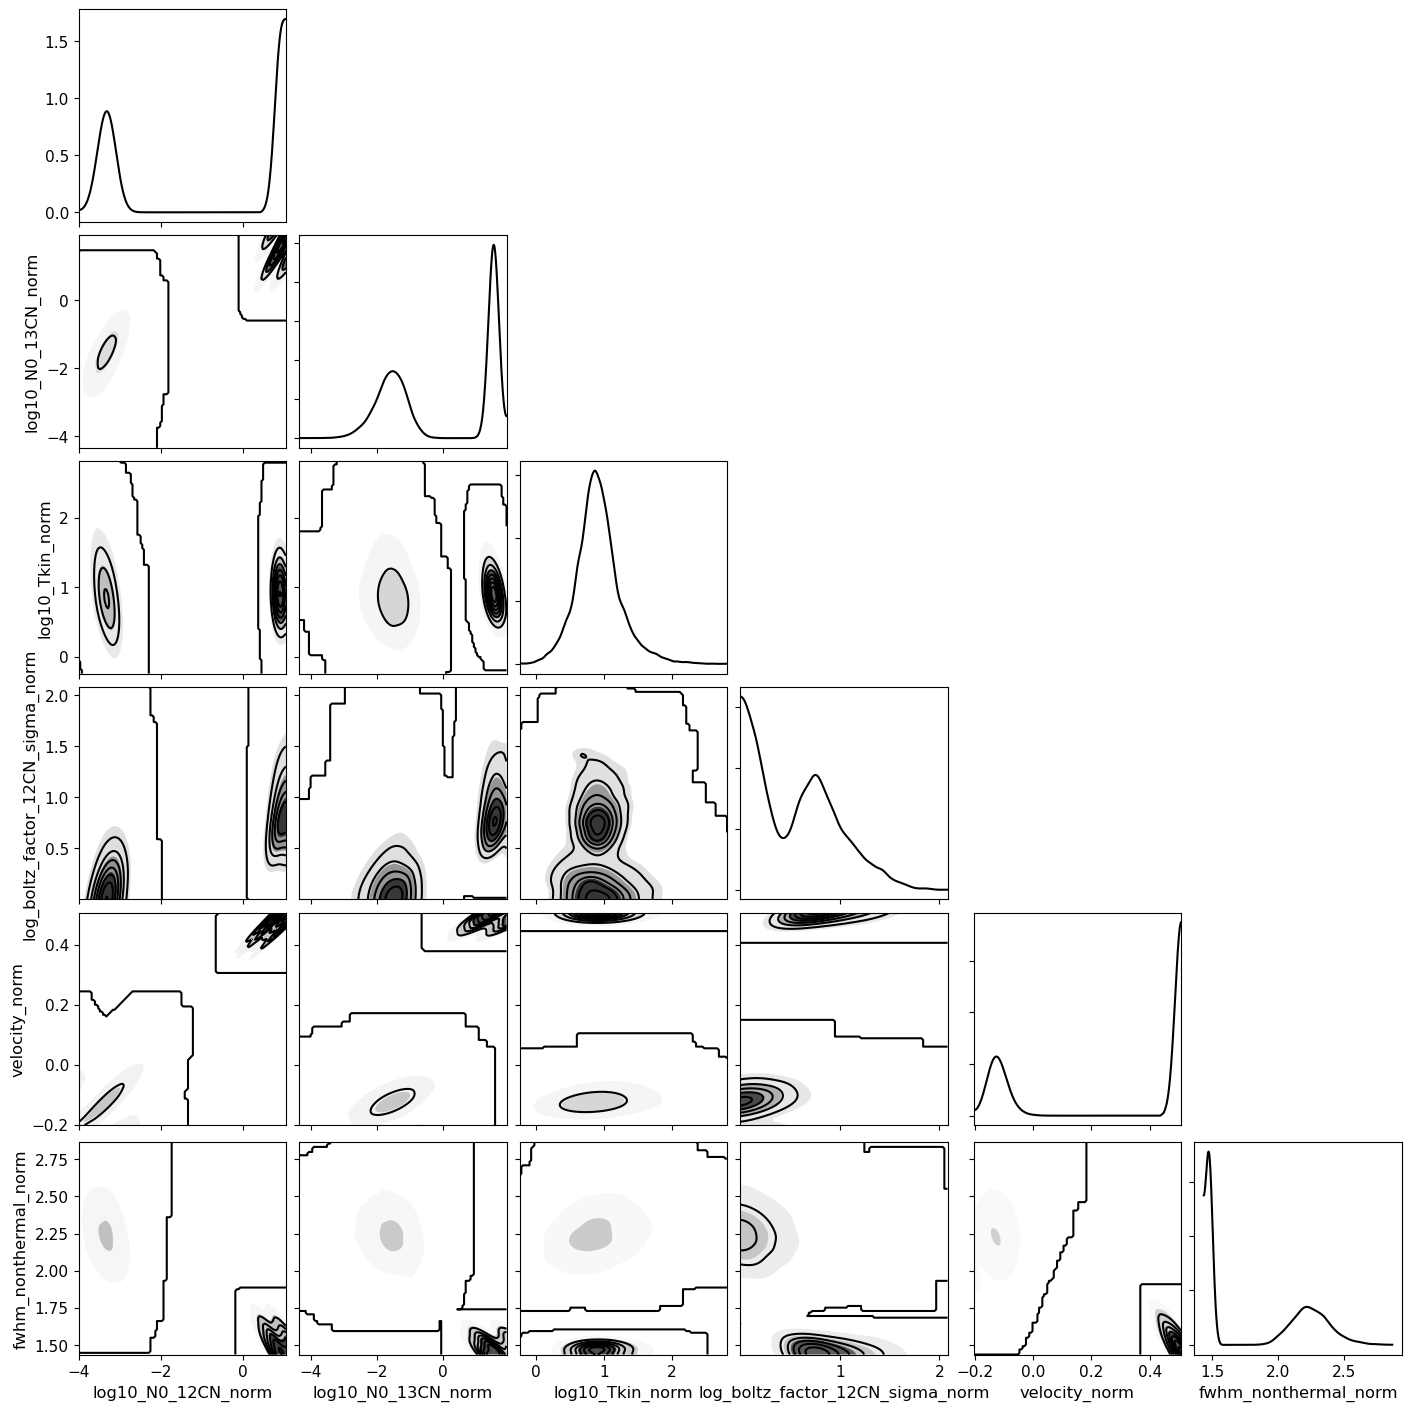

In [57]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        "transition_12CN", "transition_free_12CN", "transition_13CN",
        "state_l_12CN", "state_l_13CN"
    ]))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

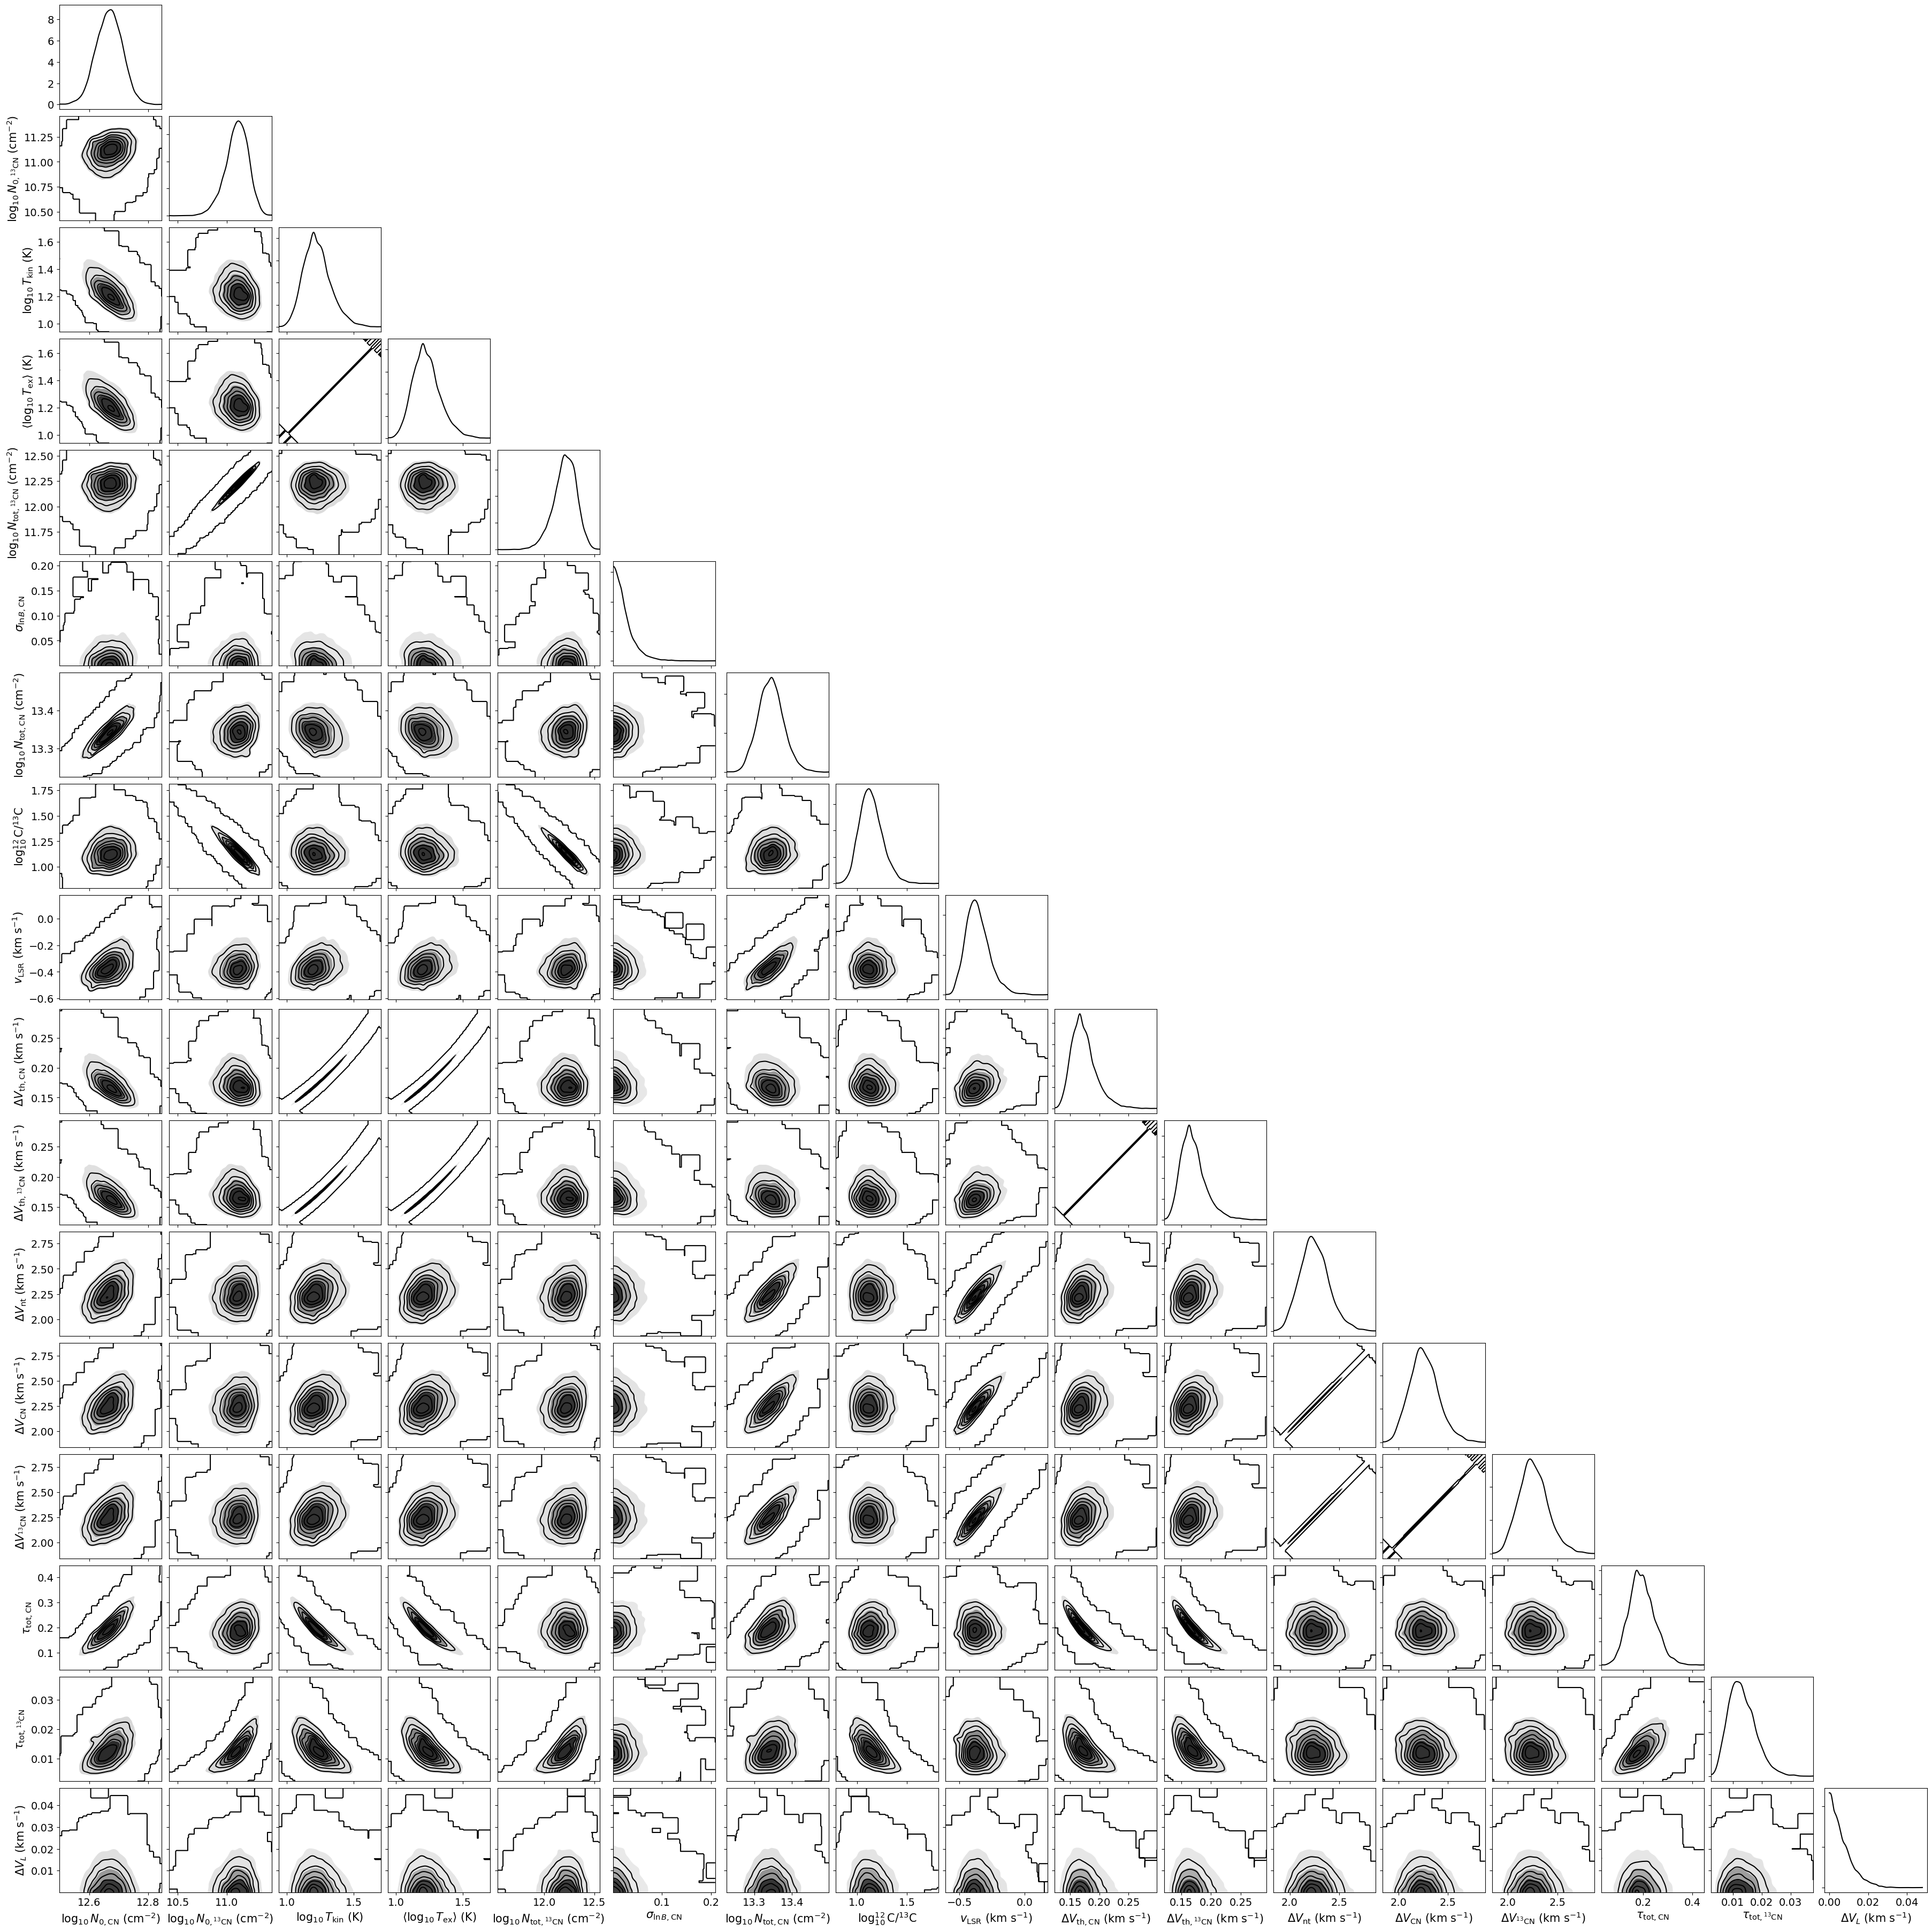

In [64]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        "transition_12CN", "transition_free_12CN", "transition_13CN",
        "state_l_12CN", "state_l_13CN"
    ]))
]
model.var_name_map.update(
            {
                "log10_N0_12CN": r"$\log_{10} N_{0, \rm CN}$ (cm$^{-2}$)",
                "log10_N0_13CN": r"$\log_{10} N_{0, ^{13}\rm CN}$ (cm$^{-2}$)",
                "log10_Tkin": r"$\log_{10} T_{\rm kin}$ (K)",
                "log10_Tex_mean": r"$\langle\log_{10} T_{\rm ex}\rangle$ (K)",
                "Tex_12CN": r"$T_{\rm ex, CN}$ (K)",
                "Tex_13CN": r"$T_{{\rm ex}, ^{13}\rm CN}$ (K)",
                "log_boltz_factor_12CN": r"$\ln B_{\rm CN}$",
                "log_boltz_factor_13CN": r"$\ln B_{^{13}\rm CN}$",
                "log_boltz_factor_12CN_mean": r"$\langle\ln B_{\rm CN}\rangle$",
                "log_boltz_factor_12CN_sigma": r"$\sigma_{\ln B, {\rm CN}}$",
                "log10_Nl_12CN": r"$\log_{10} N_{l, \rm CN}$ (cm$^{-2}$)",
                "log10_N_12CN": r"$\log_{10} N_{\rm tot, CN}$ (cm$^{-2}$)",
                "log10_Nl_13CN": r"$\log_{10} N_{l, ^{13}\rm CN}$ (cm$^{-2}$)",
                "log10_N_13CN": r"$\log_{10} N_{{\rm tot}, ^{13}\rm CN}$ (cm$^{-2}$)",
                "velocity": r"$v_{\rm LSR}$ (km s$^{-1}$)",
                "fwhm_thermal_12CN": r"$\Delta V_{\rm th, CN}$ (km s$^{-1}$)",
                "fwhm_thermal_13CN": r"$\Delta V_{{\rm th}, ^{13}\rm CN}$ (km s$^{-1}$)",
                "fwhm_nonthermal": r"$\Delta V_{\rm nt}$ (km s$^{-1}$)",
                "fwhm_12CN": r"$\Delta V_{\rm CN}$ (km s$^{-1}$)",
                "fwhm_13CN": r"$\Delta V_{^{13}\rm CN}$ (km s$^{-1}$)",
                "fwhm_L": r"$\Delta V_L$ (km s$^{-1}$)",
                "tau_12CN": r"$\tau_{\rm CN}$",
                "tau_13CN": r"$\tau_{^{13}\rm CN}$",
                "tau_total_12CN": r"$\tau_{\rm tot, CN}$",
                "tau_total_13CN": r"$\tau_{{\rm tot}, ^{13}\rm CN}$",
                "log10_12C_13C_ratio": r"$\log_{10} ^{12}{\rm C}/^{13}{\rm C}$",
            }
        )
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

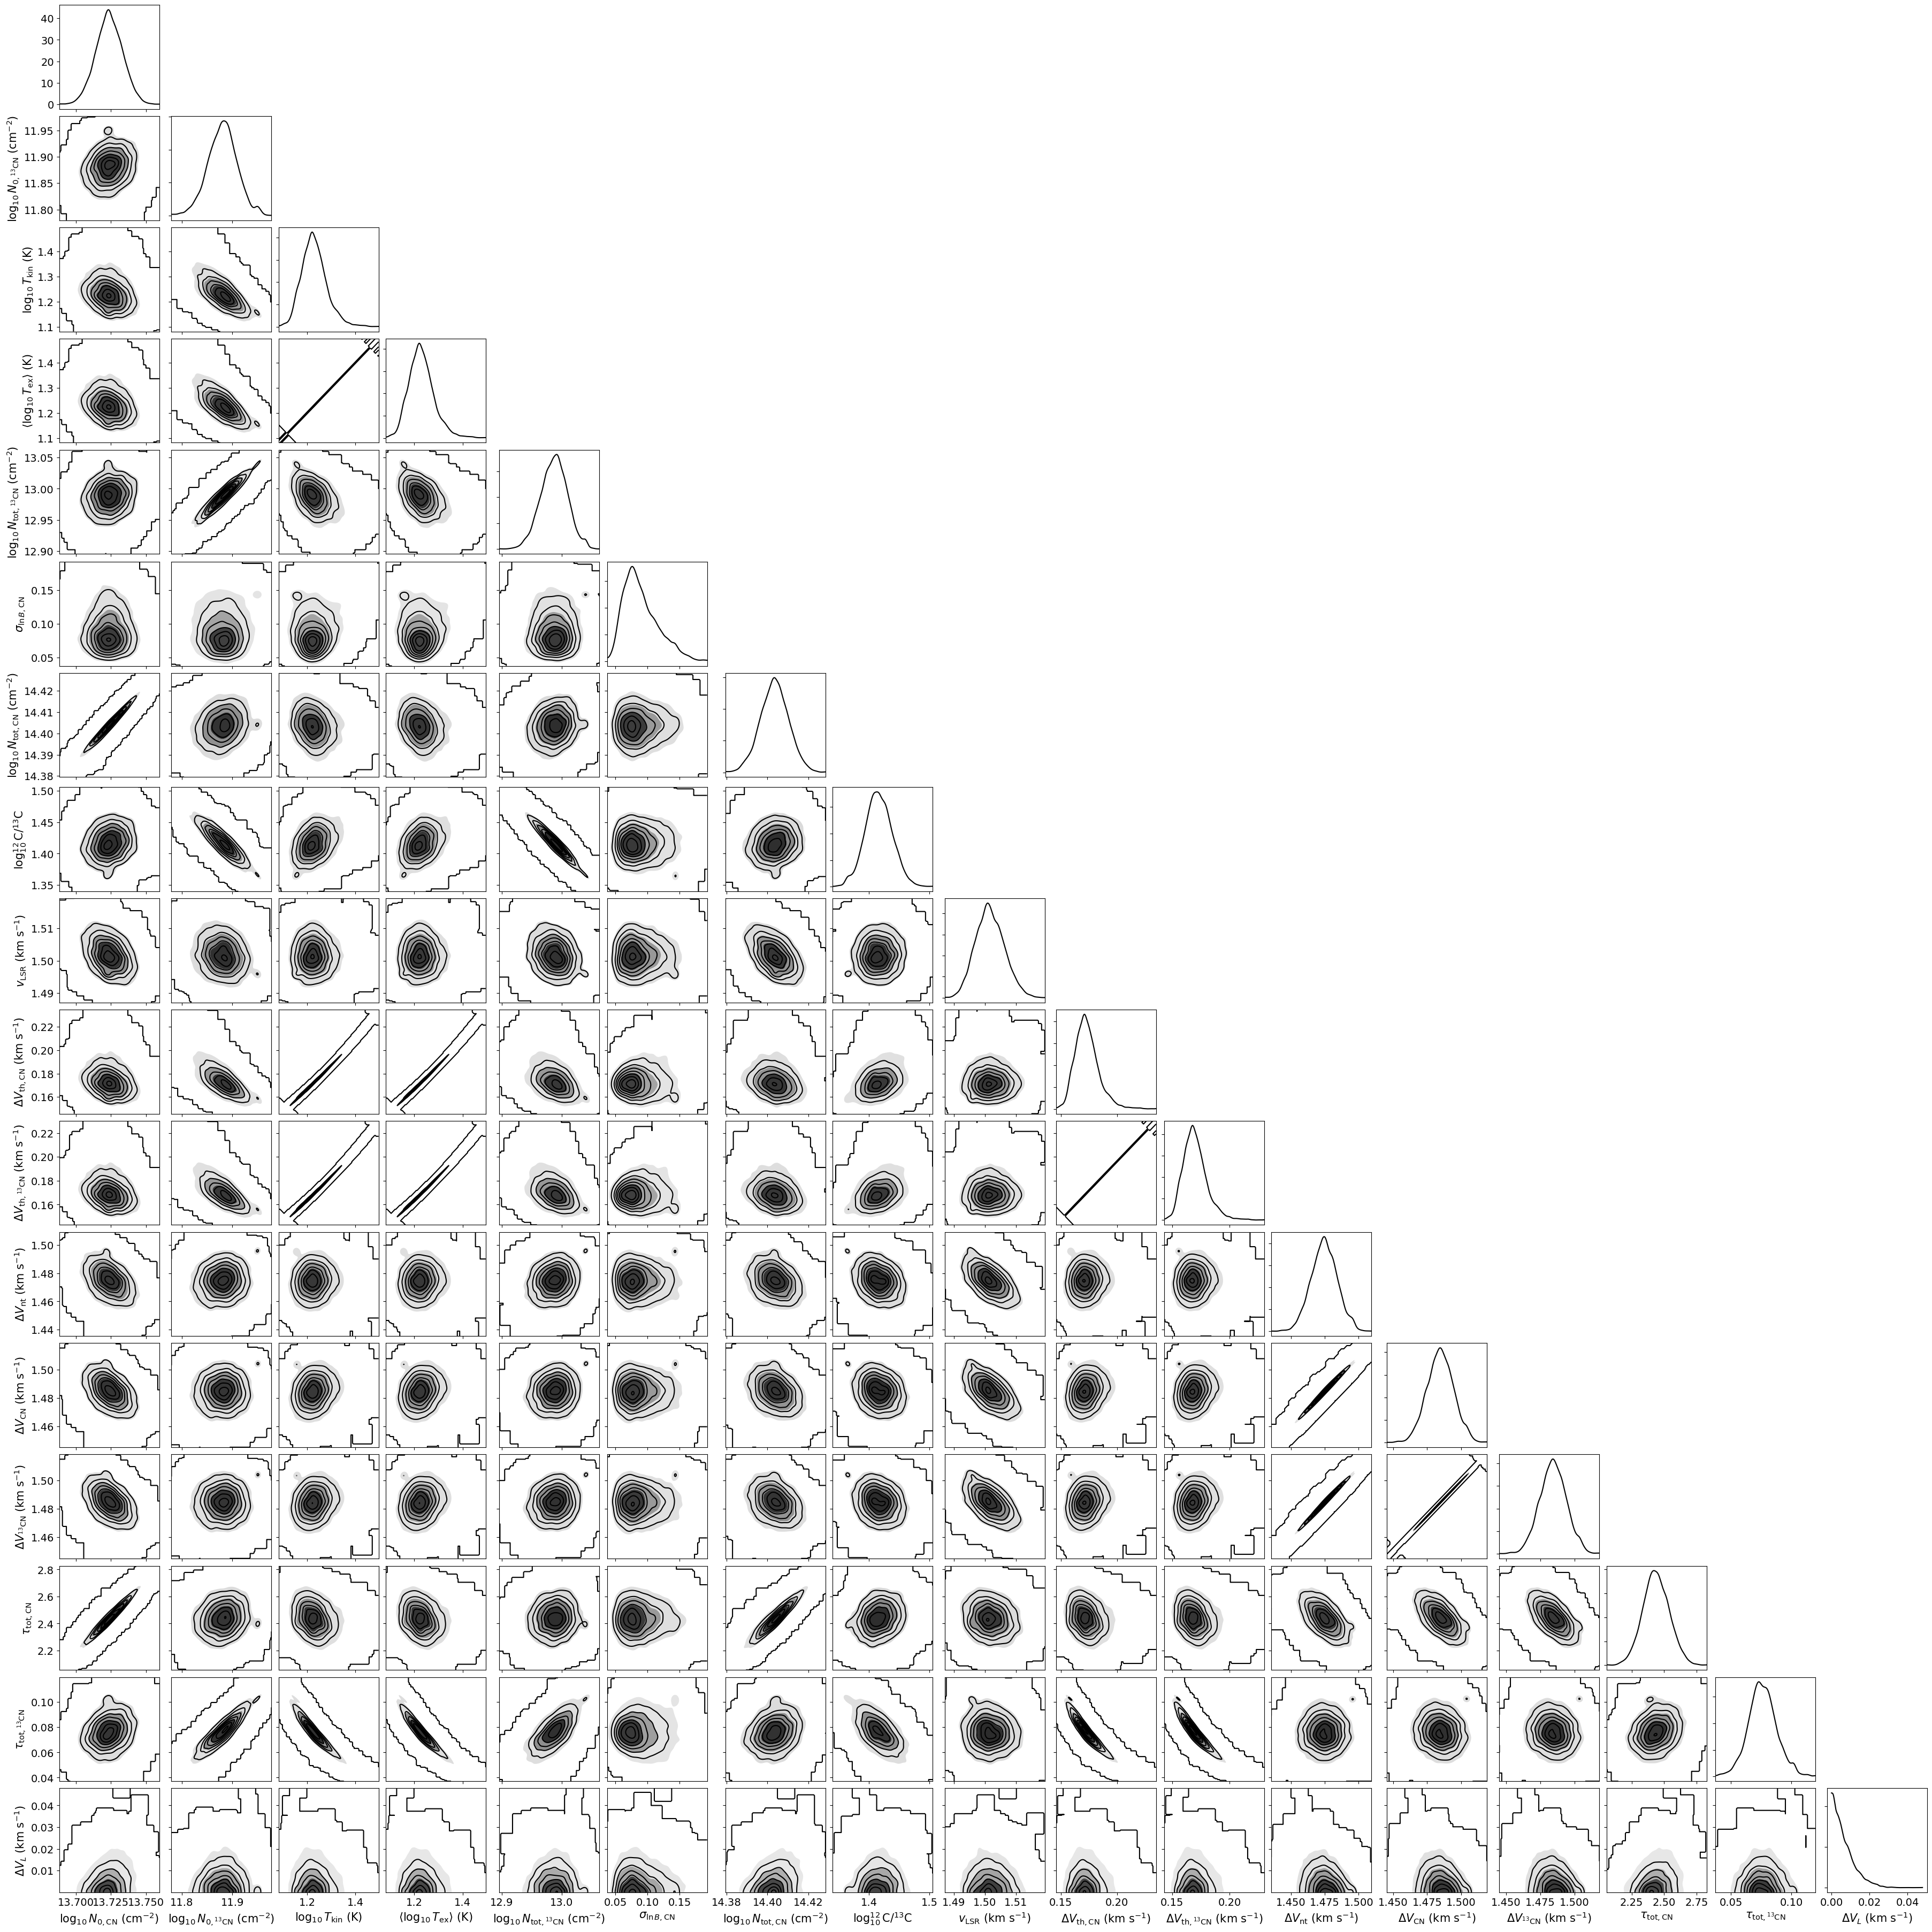

In [65]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [54]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -5044.652330349004


mean     sd  hdi_16%  hdi_84%
log10_N0_12CN[0]                            12.668  0.044   12.627   12.713
log10_N0_12CN[1]                            13.724  0.009   13.714   13.733
log10_N0_13CN[0]                            11.099  0.118   11.011   11.233
log10_N0_13CN[1]                            11.880  0.029   11.854   11.909
log10_Tkin[0]                                1.228  0.104    1.106    1.301
log10_Tkin[1]                                1.230  0.053    1.175    1.272
log10_Tex_mean[0]                            1.228  0.104    1.106    1.301
log10_Tex_mean[1]                            1.230  0.053    1.175    1.272
Tex_13CN[108056.1506, 0]                    17.427  4.570   12.509   19.636
Tex_13CN[108056.1506, 1]                    17.112  2.186   14.801   18.529
Tex_13CN[108057.1294, 0]                    17.427  4.570   12.509   19.636
Tex_13CN[108057.1294, 1]                    17.112  2.186   14.801   18.529
Tex_13CN[108062.9185, 0]                    17.427  4.570   12.509   19.636
Tex_13CN[108062.9185, 1]                    17.112  2.186   14.801   18.529
Tex_13CN[108076.9565, 0]                    17.427  4.570   12.509   19.636
Tex_13CN[108076.9565, 1]                    17.112  2.186   14.801   18.529
Tex_13CN[108077.2715, 0]                    17.427  4.570   12.509   19.636
Tex_13CN[108077.2715, 1]                    17.112  2.186   14.801   18.529
Tex_13CN[108091.3095, 0]                    17.427  4.570   12.509   19.636
Tex_13CN[108091.3095, 1]                    17.112  2.186   14.801   18.529
Tex_13CN[108406.0979, 0]                    17.427  4.570   12.509   19.636
Tex_13CN[108406.0979, 1]                    17.112  2.186   14.801   18.529
Tex_13CN[108412.862, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108412.862, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108426.889, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108426.889, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108631.121, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108631.121, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108636.923, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108636.923, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108638.212, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108638.212, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108643.59, 0]                      17.427  4.570   12.509   19.636
Tex_13CN[108643.59, 1]                      17.112  2.186   14.801   18.529
Tex_13CN[108644.3602, 0]                    17.427  4.570   12.509   19.636
Tex_13CN[108644.3602, 1]                    17.112  2.186   14.801   18.529
Tex_13CN[108645.064, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108645.064, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108651.297, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108651.297, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108657.646, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108657.646, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108658.948, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108658.948, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108780.201, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108780.201, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108782.374, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108782.374, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108786.982, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108786.982, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108793.753, 0]                     17.427  4.570   12.509   19.636
Tex_13CN[108793.753, 1]                     17.112  2.186   14.801   18.529
Tex_13CN[108796.4,

In [55]:
print(sim_params)
print(derived_params)

{'log10_N0_12CN': [13.7, 12.6], 'log10_N0_13CN': [11.9, 10.8], 'log10_Tkin': [1.2, 1.5], 'log10_Tex_mean': [1.2, 1.3], 'fwhm_nonthermal': [1.5, 2.0], 'velocity': [1.5, -0.5], 'fwhm_L': 0.0, 'baseline_12CN_norm': [0.0], 'baseline_13CN_norm': [0.0], 'log_boltz_factor_12CN_sigma': array([0.1 , 0.05]), 'log_boltz_factor_12CN_free_norm': array([[ 0.47143516, -0.59548785],
       [ 1.43270697, -0.15632595],
       [-0.72058873,  0.44358147],
       [ 0.85958841, -0.31826175],
       [ 0.01569637, -1.12134248],
       [ 1.15003572,  0.49597301]])}
{'log10_N_12CN': array([14.38910918, 13.29028563]), 'tau_total_12CN': array([2.14982459, 0.14861401]), 'log10_N_13CN': array([13.00100736, 11.92142609]), 'tau_total_13CN': array([0.0836229 , 0.00545025]), 'log10_12C_13C_ratio': array([1.38810181, 1.36885955])}
